# Выделение групп пользователей приложения на основе поведения

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import os

## Загрузка и общий обзор данных.

Загрузим данные, проверим, корректно ли они загрузились, и посмотрим на количество пропусков.

In [2]:
sources_path = os.path.join(os.path.abspath(''), 'datasets/mobile_sources.csv')
sources = pd.read_csv(sources_path)

data_path = os.path.join(os.path.abspath(''), 'datasets/mobile_dataset.csv')
data = pd.read_csv(data_path)

In [3]:
sources.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [4]:
data.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [5]:
sources.info()
print()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


**Вывод**: данные успешно загружены, пропусков нет, можно переходить к предобработке данных.

## Предобработка данных.

### Переименование столбцов.

Для удобства переименуем столбцы.

In [6]:
data.columns = data.columns.map(
    lambda x: x.replace('.', '_')
)
sources = sources.rename(columns={'userId': 'user_id'})
print('Колонки data:', end=' ')
print(*data.columns, sep=', ')

print('Колонки sources:', end=' ')
print(*sources.columns, sep=', ')

Колонки data: event_time, event_name, user_id
Колонки sources: user_id, source


### Преобразование `event_time`.

Преобразуем столбец event_time из строки в datetime.

In [7]:
data['event_time'].head()

0    2019-10-07 00:00:00.431357
1    2019-10-07 00:00:01.236320
2    2019-10-07 00:00:02.245341
3    2019-10-07 00:00:07.039334
4    2019-10-07 00:00:56.319813
Name: event_time, dtype: object

In [8]:
data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')
data['event_time'].head()

0   2019-10-07 00:00:00.431357
1   2019-10-07 00:00:01.236320
2   2019-10-07 00:00:02.245341
3   2019-10-07 00:00:07.039334
4   2019-10-07 00:00:56.319813
Name: event_time, dtype: datetime64[ns]

### Обработка дубликатов.

Из информации о датасете известно, что в столбце `event_name` есть неявный дубликат contacts_show и show_contacts.

In [9]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [10]:
data.loc[
    data['event_name'] == 'show_contacts', 
    'event_name'
] = 'contacts_show'

data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

show_contacts были приведены к contacts_show, других неявных дубликатов не нашлось. Посмотрим есть ли явные дубликаты.

In [11]:
print('Количество явных дубликатов в data:', data.duplicated().sum())
print('Количество явных дубликатов в sources:', sources.duplicated(subset=['user_id']).sum())

Количество явных дубликатов в data: 0
Количество явных дубликатов в sources: 0


### Объединение поисковых запросов.

Будем смотреть на поисковые запросы в целом, без разреза по их типу.

In [12]:
data['event_name'] = data['event_name'].apply(lambda x: 'search' if 'search' in x else x)

### Вывод.

* Пропусков нет;
* Столбцы для удобства переименованы;
* Время событий приведено к типу datetime;
* Единственный дубликат - это значения 'show_contacts' и 'contacts_show' в столбце `event_name`.

## Исследовательский анализ данных.

### Временной период, охватываемый данными.

In [13]:
print('Дата и время первого события:', data['event_time'].min())
print('Дата и время последнего события:', data['event_time'].max())
print('Размер временного периода:', data['event_time'].max() - data['event_time'].min())

Дата и время первого события: 2019-10-07 00:00:00.431357
Дата и время последнего события: 2019-11-03 23:58:12.532487
Размер временного периода: 27 days 23:58:12.101130


Данные охватывают примерно 27-28 дней, посмотрим на число событий в каждый из дней. Может оказаться, что событий в начале периода или конце периода мало.

Добавим для удобства столбец с датой событий к таблице.

In [14]:
data['event_date'] = pd.to_datetime(data['event_time'].dt.date)
data['event_date'].head()

0   2019-10-07
1   2019-10-07
2   2019-10-07
3   2019-10-07
4   2019-10-07
Name: event_date, dtype: datetime64[ns]

### Распределение событий по дням.

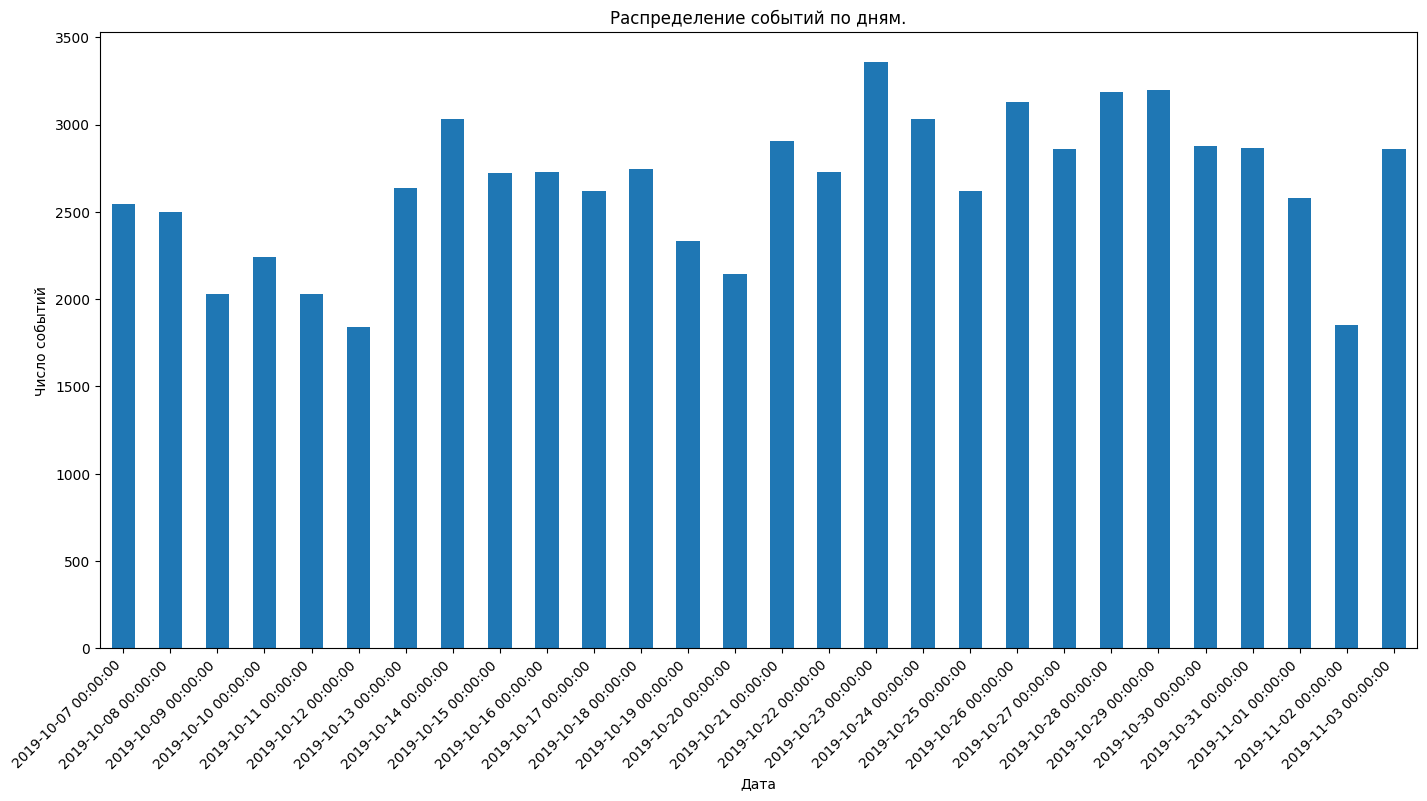

In [15]:
(
    data[['event_date', 'user_id']]
    .groupby('event_date')
    .count()
    .plot.bar(
        figsize=(17, 8),
        legend='',
        title='Распределение событий по дням.',
        xlabel='Дата',
        ylabel='Число событий'
    )
)
plt.xticks(rotation=45, ha='right');

В каждый из дней пользователи совершали достаточно много событий, нет смысла отбрасывать какие-то дни.

### Распределение источников установки приложения.

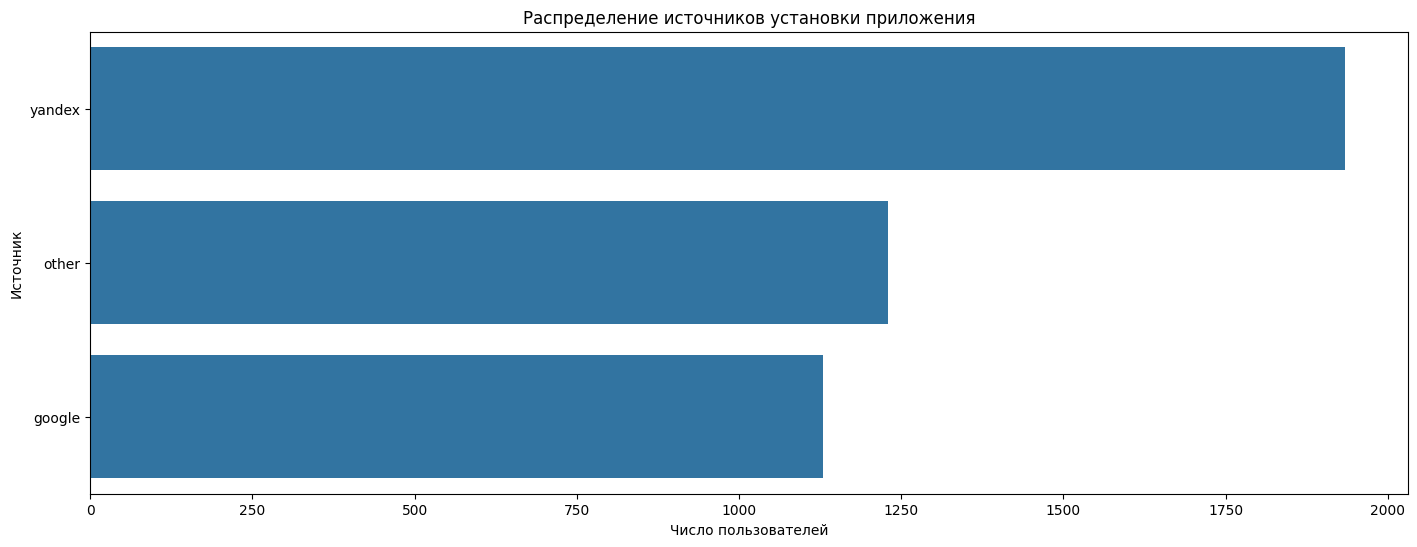

In [16]:
plt.figure(figsize=(17, 6))
sns.barplot(
    data=(
        sources
        .groupby('source', as_index=False)
        .count()
        .sort_values(by='user_id', ascending=False)
    ),
    x='user_id',
    y='source',
).set(
    title='Распределение источников установки приложения',
    xlabel='Число пользователей',
    ylabel='Источник'
);

Пользователей из Яндекса существенно больше, чем из Гугла и других источников.

### Вывод.

* Данные охватывают промежуток с 2019-10-07 по 2019-11-03;
* В каждый из дней совершалось много событий - не менее 1800;
* Пользователей, пришедших от Яндекса, намного больше, чем от Гугла или других источников.

## Функции для рассчёта и визуализации метрик.

### Удержание.

In [17]:
def get_retention(data, horizon_days=7, dimensions=[]):
    # фильтрация по горизонту
    last_suitable_date = data['first_date'].max()
    last_suitable_date -= timedelta(days=horizon_days - 1)
    result_raw = data.query('first_date <= @last_suitable_date').copy()
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_date'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [18]:
# функция сглаживания
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(1, 2, 1)
    retention.T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax2 = plt.subplot(1, 2, 2)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name != 'first_date'
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.pivot_table(
        index='first_date', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Конверсия.

In [20]:
def get_conversion(
    data, 
    horizon_days=7, 
    dimensions=[], 
    window=7, 
    ignore_horizon=False
):
    # фильтрация по горизонту
    last_suitable_date = data['first_date'].max()
    if not ignore_horizon:
        last_suitable_date -= timedelta(days=horizon_days - 1)
    result_raw = data.query('first_date <= @last_suitable_date').copy()

     # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        data
        .query('event_name == "contacts_show"')
        .groupby('user_id')
        .agg({'event_date': 'min'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.drop(columns='event_date').merge(
        first_purchases[['user_id', 'event_date']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_date'] - result_raw['first_date']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days, ignore_horizon=ignore_horizon):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        if not ignore_horizon:
            result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result
        
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['first_date'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['first_date']
    ]
    filtered_data = conversion_history.pivot_table(
        index='first_date', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, legend='')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Общее поведение пользователей.

### Выделение сессий пользователей.

Под сессией будем понимать один календарный день. Для дальнейших вычислений понадобиться отсортировать события по идентификаторам пользователей и по времени.

In [22]:
data = data.sort_values(['user_id', 'event_time']).reset_index(drop=True)

Теперь выделим дату первого события для каждого пользователя и вычислим лайфтайм, его будет достаточно, чтобы различать сессии друг от друга, и он пригодится для вычисления retention rate.

In [23]:
data['first_date'] = data[['event_date', 'user_id']].groupby('user_id').transform('min')
data['lifetime'] = (data['event_date'] - data['first_date']).dt.days

### Retention rate.

Рассчитаем retention rate и визуализируем его, горзионт анализа возьмём равным 11 дней - этого хватит, так как около 90% пользователей каждой когорты покидает приложение в первые 3 дня, а дальше многие пользователи пропадают на несколько дней и возвращаются.

In [24]:
_, retention, retention_history = get_retention(data, horizon_days=11)

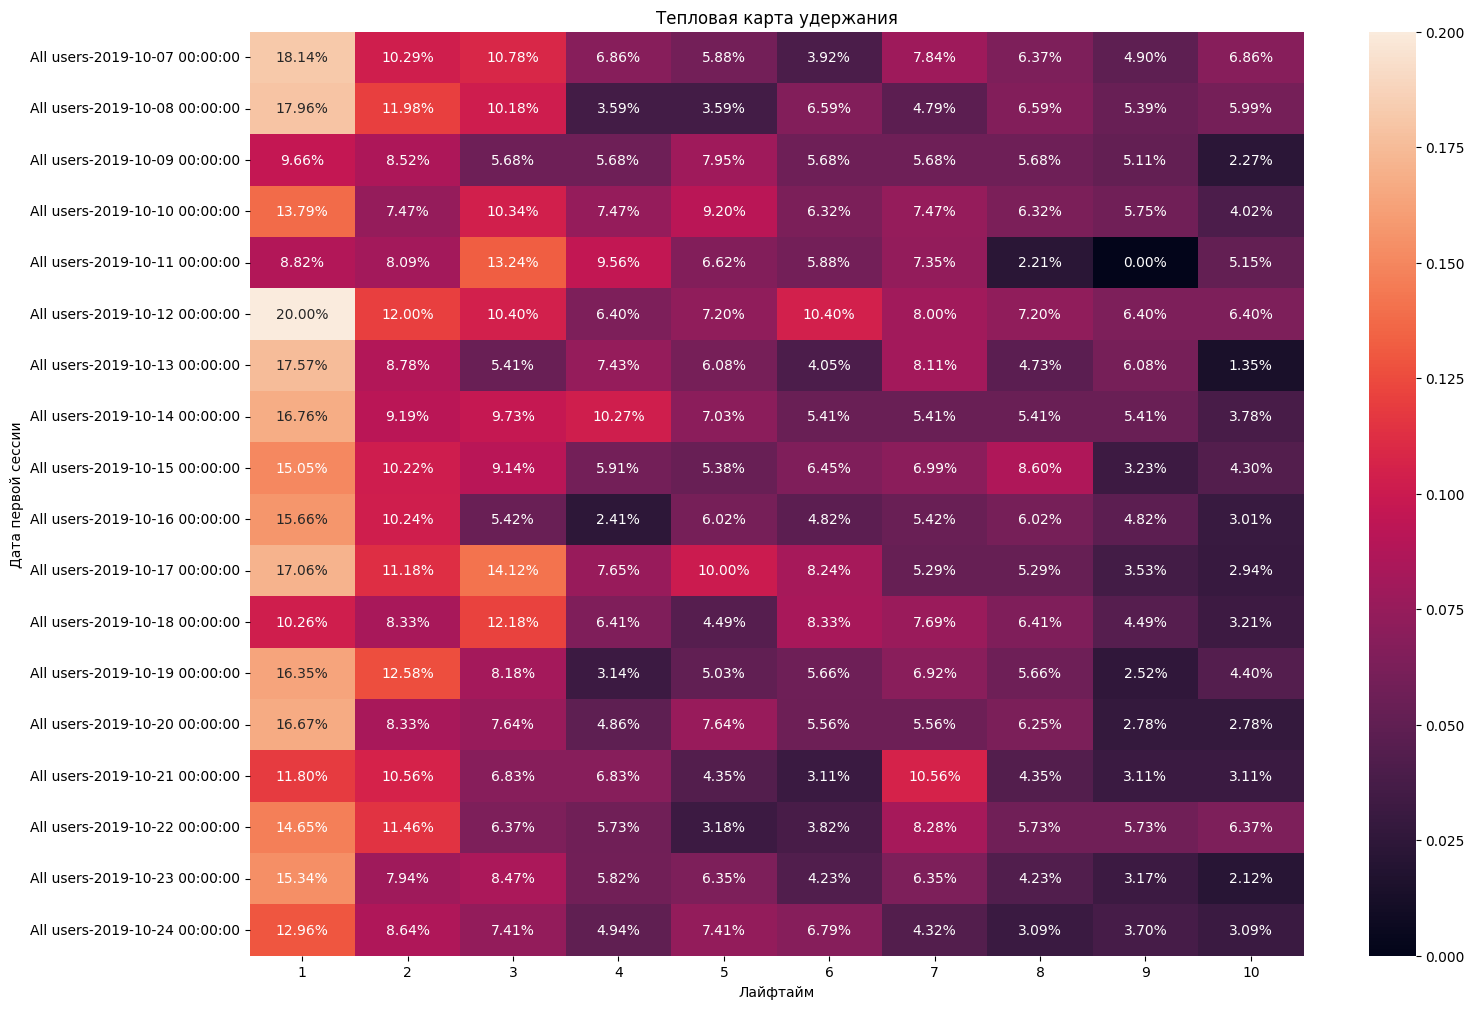

In [25]:
plt.figure(figsize=(17, 12))
sns.heatmap(
    retention_history.drop(columns=['cohort_size', 0]),
    annot=True, 
    fmt='.2%',
).set(
    title='Тепловая карта удержания',
    ylabel='Дата первой сессии',
    xlabel='Лайфтайм'
);

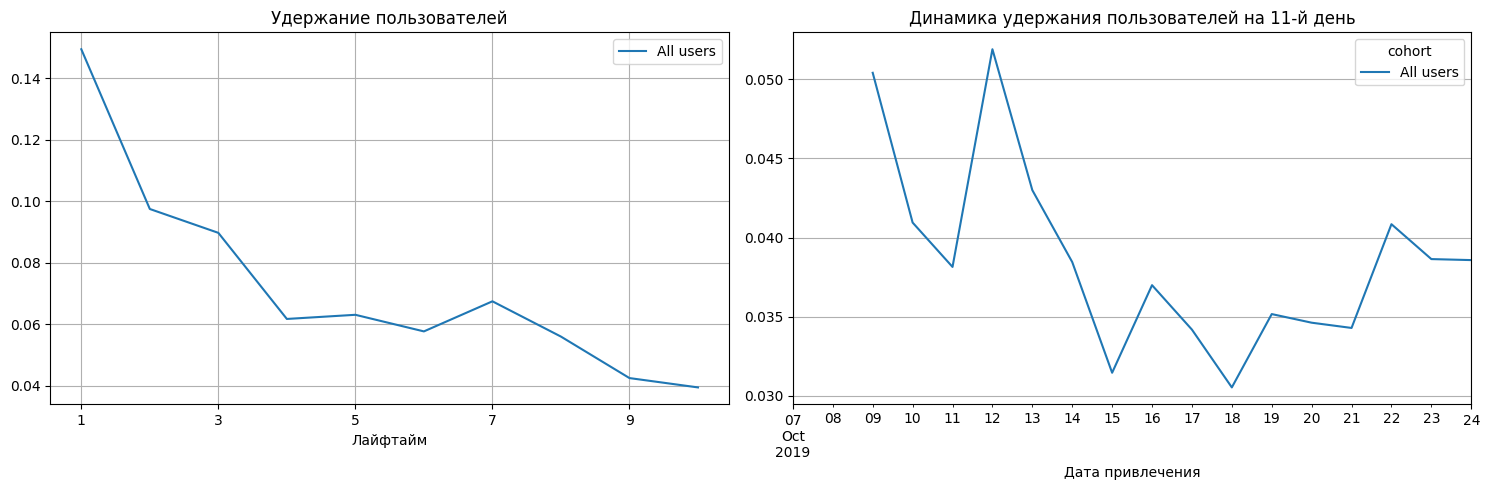

In [26]:
plot_retention(retention, retention_history, horizon=11, window=3)

**Вывод:** 
* К 4 дню уходит около 90% пользователей каждой когорты;
* Оставшиеся пользователи заходят в приложение не каждый день - например в когорте от 2019-10-21 с 6 на 7 день вернулось около 7% пользователей;
* Через 10 дней в приложении остается около 4% пользователей.

### Время в приложении.

Чтобы посчитать время проведенное в приложении, посчитаем разницу во времени между последним и первым событием в сессии. Время будем считать в минутах.

In [27]:
sessions_time = (
    data
    .groupby(['user_id', 'lifetime'], as_index=False)
    .agg({
        'event_time': lambda x: (max(x) - min(x))
    })
)
sessions_time['event_time'] = sessions_time['event_time'].dt.seconds // 60

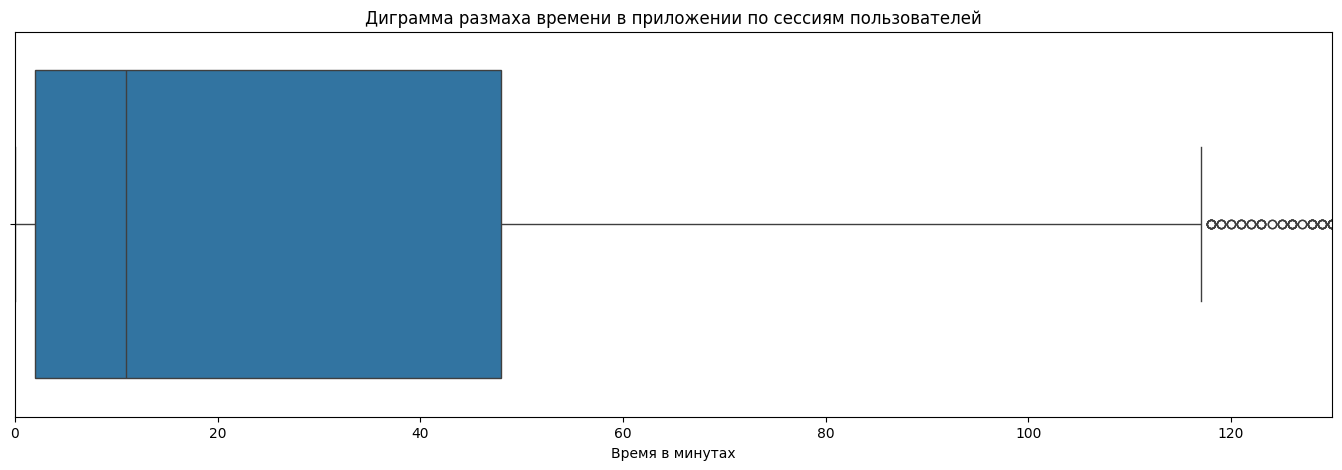

In [28]:
plt.figure(figsize=(17, 5))
sns.boxplot(data=sessions_time, x='event_time').set(
    title='Диграмма размаха времени в приложении по сессиям пользователей',
    xlabel='Время в минутах'
)
plt.xlim(0, 130);

In [29]:
print(
    'Медиана времени в приложении: {time_median} минут.'.format(
        time_median=int(sessions_time['event_time'].median())
    )
)

Медиана времени в приложении: 11 минут.


**Вывод:**
* В среднем пользователи проводят в приложении приблизительно 11 минут;
* Если отбросить выбросы, то можно считать, что пользователи проводят в приложении до 2 часов.

### Частота действий.

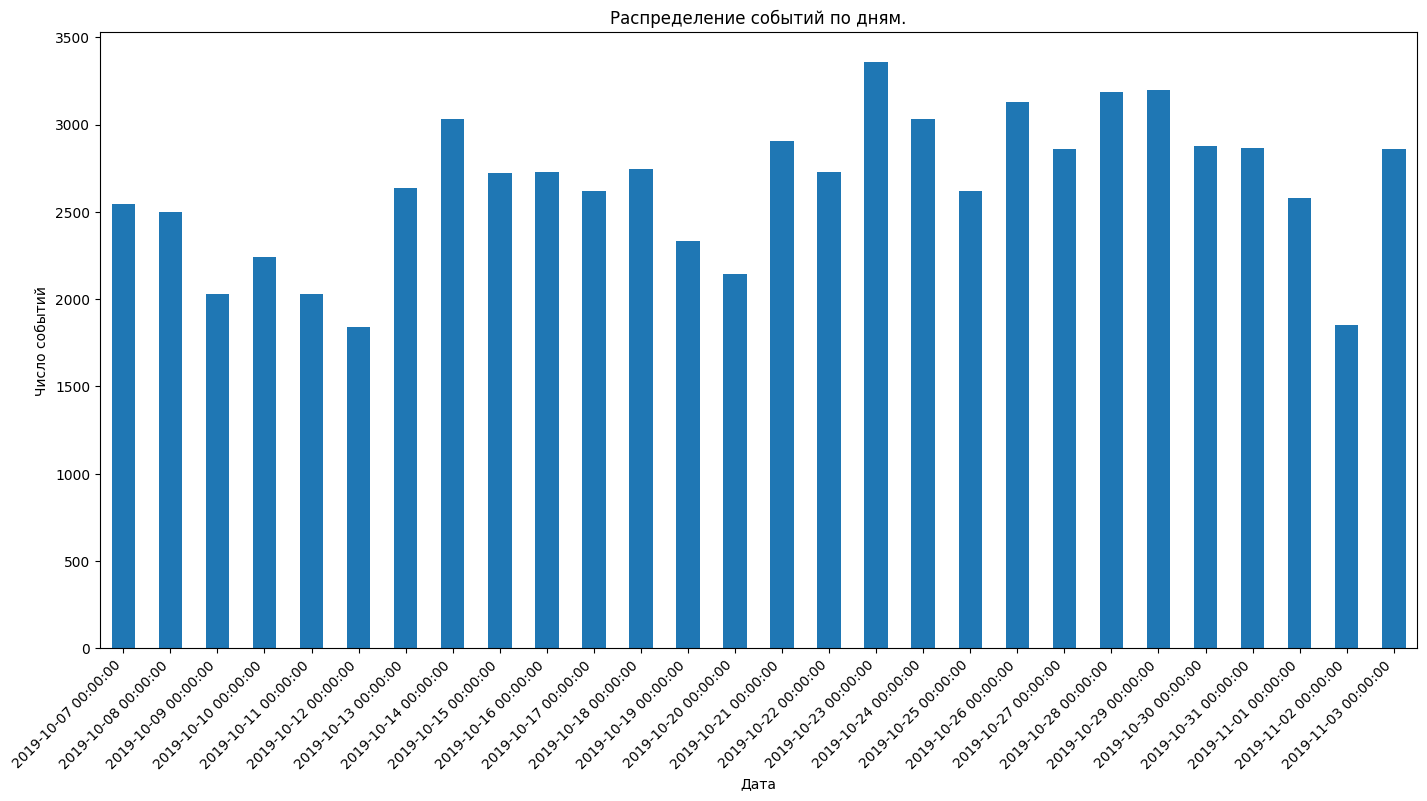

In [30]:
(
    data[['event_date', 'user_id']]
    .groupby('event_date')
    .count()
    .plot.bar(
        figsize=(17, 8),
        legend='',
        title='Распределение событий по дням.',
        xlabel='Дата',
        ylabel='Число событий',
    )
)
plt.xticks(rotation=45, ha='right');

Посчитаем сколько различных действий выполняет пользователь за день в среднем.

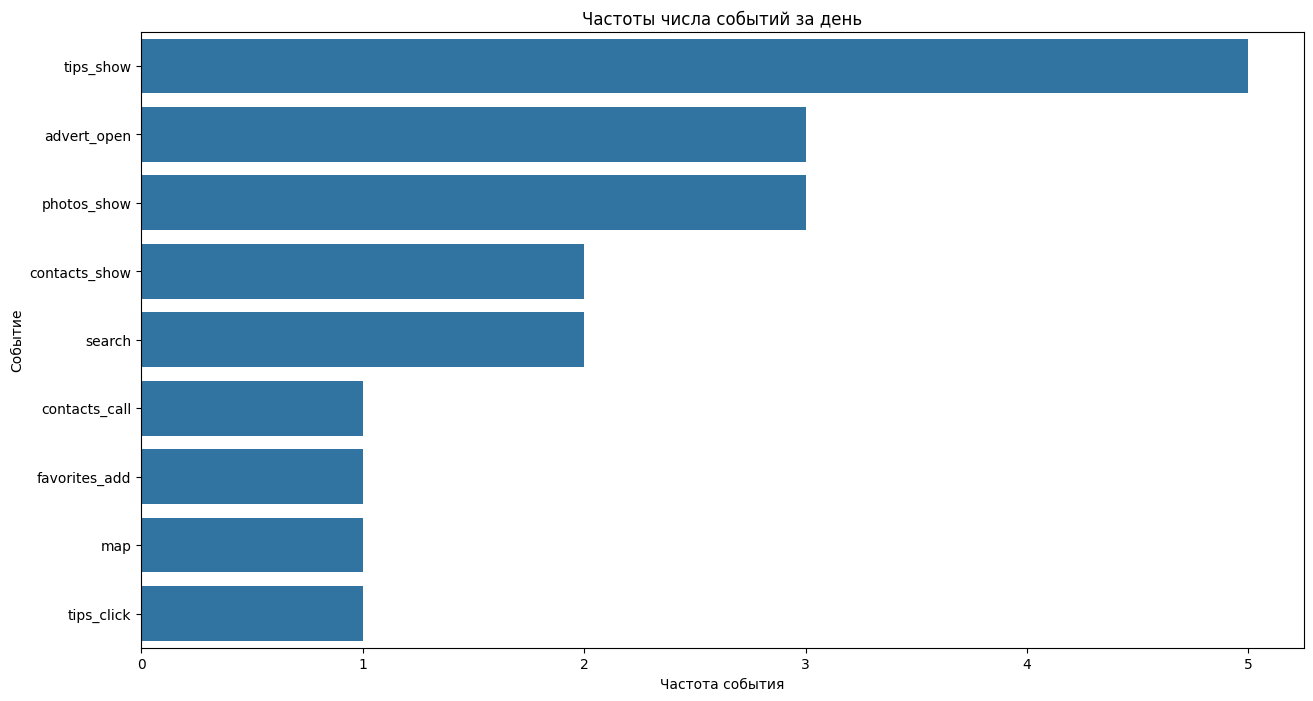

In [31]:
plt.figure(figsize=(15, 8))
sns.barplot(
    data=(
        # Число событий каждого типа у каждого пользователя за каждый день,
        data[['event_time', 'user_id', 'event_name', 'event_date']]
        .groupby(['event_name', 'event_date', 'user_id'], as_index=False)
        .count()
        # Получим медиану каждого события по сессиям.
        .groupby(['event_name'], as_index=False)
        .agg({'event_time': 'median'})
        .sort_values(by='event_time', ascending=False)
    ),
    x='event_time',
    y='event_name'
).set(
    title='Частоты числа событий за день',
    xlabel='Частота события',
    ylabel='Событие'
);

**Вывод:** 
* Никакого четкого подъема или падения в числе событий во времени не видно;
* Пользователи видят рекомендованные объявления примерно 5 раз в день;
* Пользователи смотрят 3 объявления в день и одно из них рекомендованное;

### Конверсия в просмотр контактов.

Посмотрим на конверсию в просмотр контактов за неделю и её динамику.

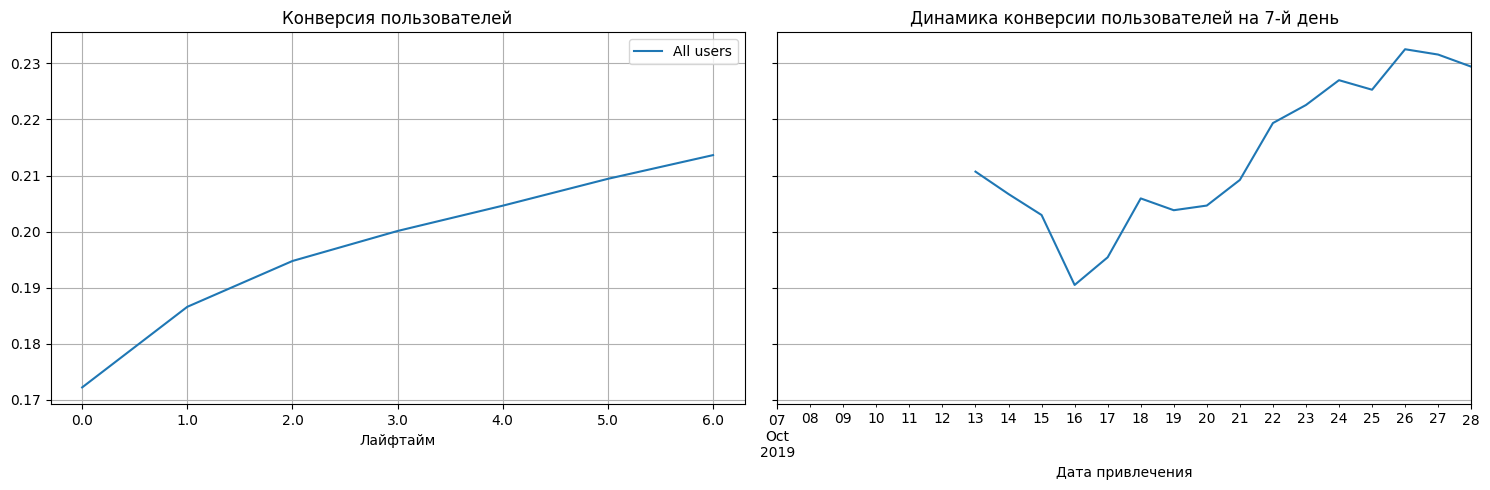

In [32]:
_, conversion, conversion_history = get_conversion(data, horizon_days=7)
plot_conversion(conversion, conversion_history, horizon=7)

**Вывод:** к концу недели конверсия достигает примерно 21%, начиная с 16-го числа конверсия, достигаемая на 7-ой день, возросла примерно на 4%.

### Вывод.

**Удержание:**
* Retention rate позволил понять, что при разбиении пользователей по дням их прихода к 4 дню уходит около 90% пользователей каждой когорты;
* Пользователи, которые не ушли в первые дни, заходят в прилоэение не каждый день - например в когорте от 2019-10-21 с 6 на 7 день вернулось около 7% пользователей;
* Через 10 дней в приложении остается около 4% пользователей.

**Время в приложении:**
* Можно считать, что пользователи проводят в приложении около 11 минут - листают объявления не долго.

**Частота действий:**
* Пользователи видят рекомендованные объявления примерно 5 раз в день;
* Пользователи смотрят 3 объявления в день и одно из них рекомендованное;
* Пользователи совершают целевое действие - просмотр контактов около 2 раз за сессию.

**Конверсия в просмотр контактов:**
* К концу недели конверсия достигает примерно 21%, начиная с 16-го числа конверсия, достигаемая на 7-ой день, возросла примерно на 4%.

## Сегментация пользователей.

Сегментируем пользователей по среднему числу событий за день. Это позволит понять, как поведение пользователей связано с их удержанием, конверсией и остальными метриками. Интуиция говорит, что пользователи, которые взаимодействуют с платформой больше, лучше удерживаются, и имеют большую конверсию, т.е. частота событий напрямую связана с заинтересованностью пользователей, однако это надо проверить.

In [33]:
# Вычисление медианы событий за сессию для каждого пользователя
event_count = (
        data[['user_id', 'lifetime', 'event_name']]
        .groupby(['user_id', 'lifetime'], as_index=False)
        .count()
        .rename(columns={'event_name': 'event_median'})
        .groupby('user_id', as_index=False)['event_median']
        .median()
)
data = data.merge(
    event_count,
    on='user_id',
    how='left'
)

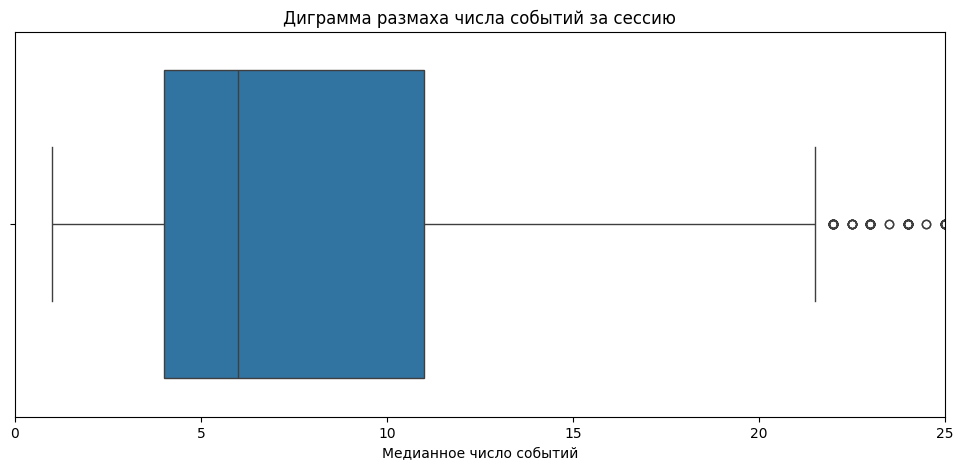

In [34]:
plt.figure(figsize=(12,  5))
sns.boxplot(data=event_count, x='event_median').set(
    title='Диграмма размаха числа событий за сессию',
    xlabel='Медианное число событий'
)
plt.xlim(0, 25);

Воспользуемся диграммой размаха для разбиения пользователей на группы. 50% пользователей совершают от 4 до 11 действий, поэтому их отнесём к "средней" группе по частоте действий. Добавим ещё 2 группы: с большим и меньшим числом действий. Полученные группы будут не сбалансированны. 

In [35]:
def classify_freq(x, lower=int(event_count['event_median'].quantile(0.25)), upper=int(event_count['event_median'].quantile(0.75))):
    if x < lower:
        return 'low'
    if x > upper:
        return 'high'
    return 'mid'

data['group'] = data['event_median'].apply(classify_freq)

In [36]:
data.groupby('group')['user_id'].nunique()

group
high    1060
low      854
mid     2379
Name: user_id, dtype: int64

## Поведение пользователей по группам.

### Retention rate.

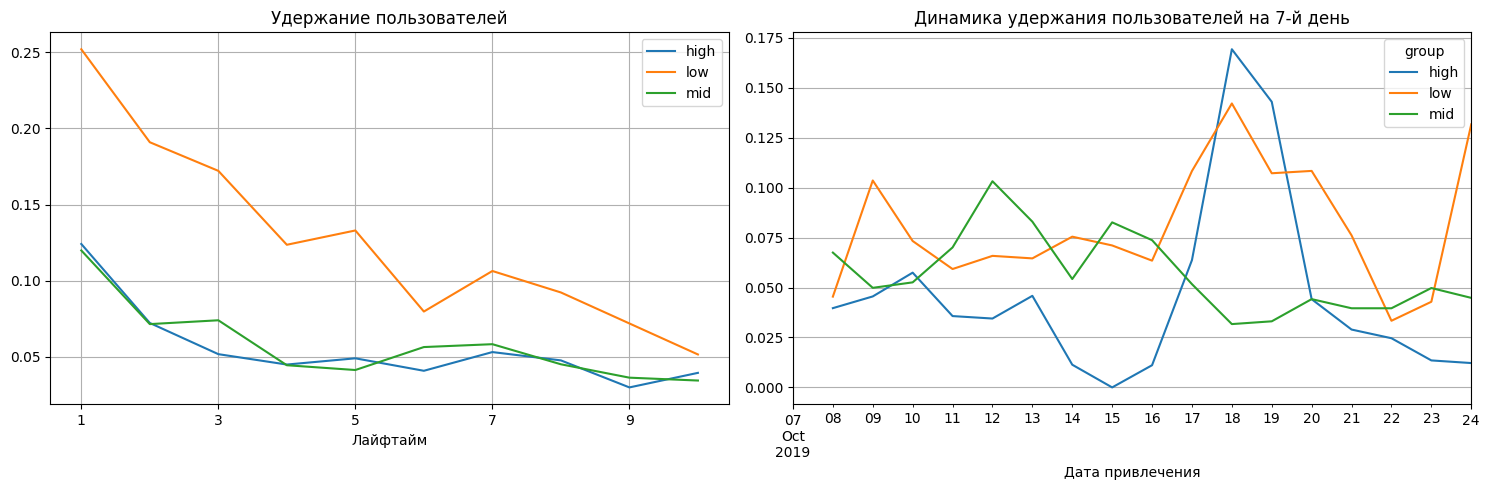

In [37]:
_, retention, retention_history = get_retention(data, horizon_days=11, dimensions=['group'])
plot_retention(retention, retention_history, horizon=7, window=2)

* Удержание пользователей, которые совершают мало действий заметно больше на всём лайфтайме;
* В период с 17 по 19 число наблюдался большой прирост пользователей, совершающих много действий, которые остались заинтересованы в приложении.

### Время в приложении.

In [38]:
sessions_time = (
    data
    .groupby(['user_id', 'lifetime'], as_index=False)
    .agg({
        'event_time': lambda x: (max(x) - min(x)),
        'group': 'first'
    })
)
sessions_time['event_time'] = sessions_time['event_time'].dt.seconds // 60

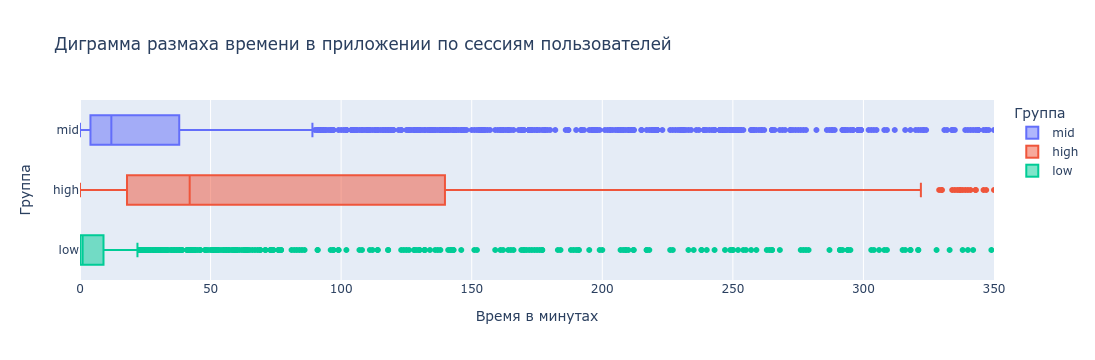

In [39]:
fig = px.box(
    sessions_time, 
    x='event_time', 
    y='group', color='group', 
    range_x=(0, 350),
    title='Диграмма размаха времени в приложении по сессиям пользователей',
    labels={
        'event_time': 'Время в минутах',
        'group': 'Группа'
    }
)
fig.show()

Пользователи, которые совершают больше действий, действительно, проводят больше времени в приложении.

### Частота действий.

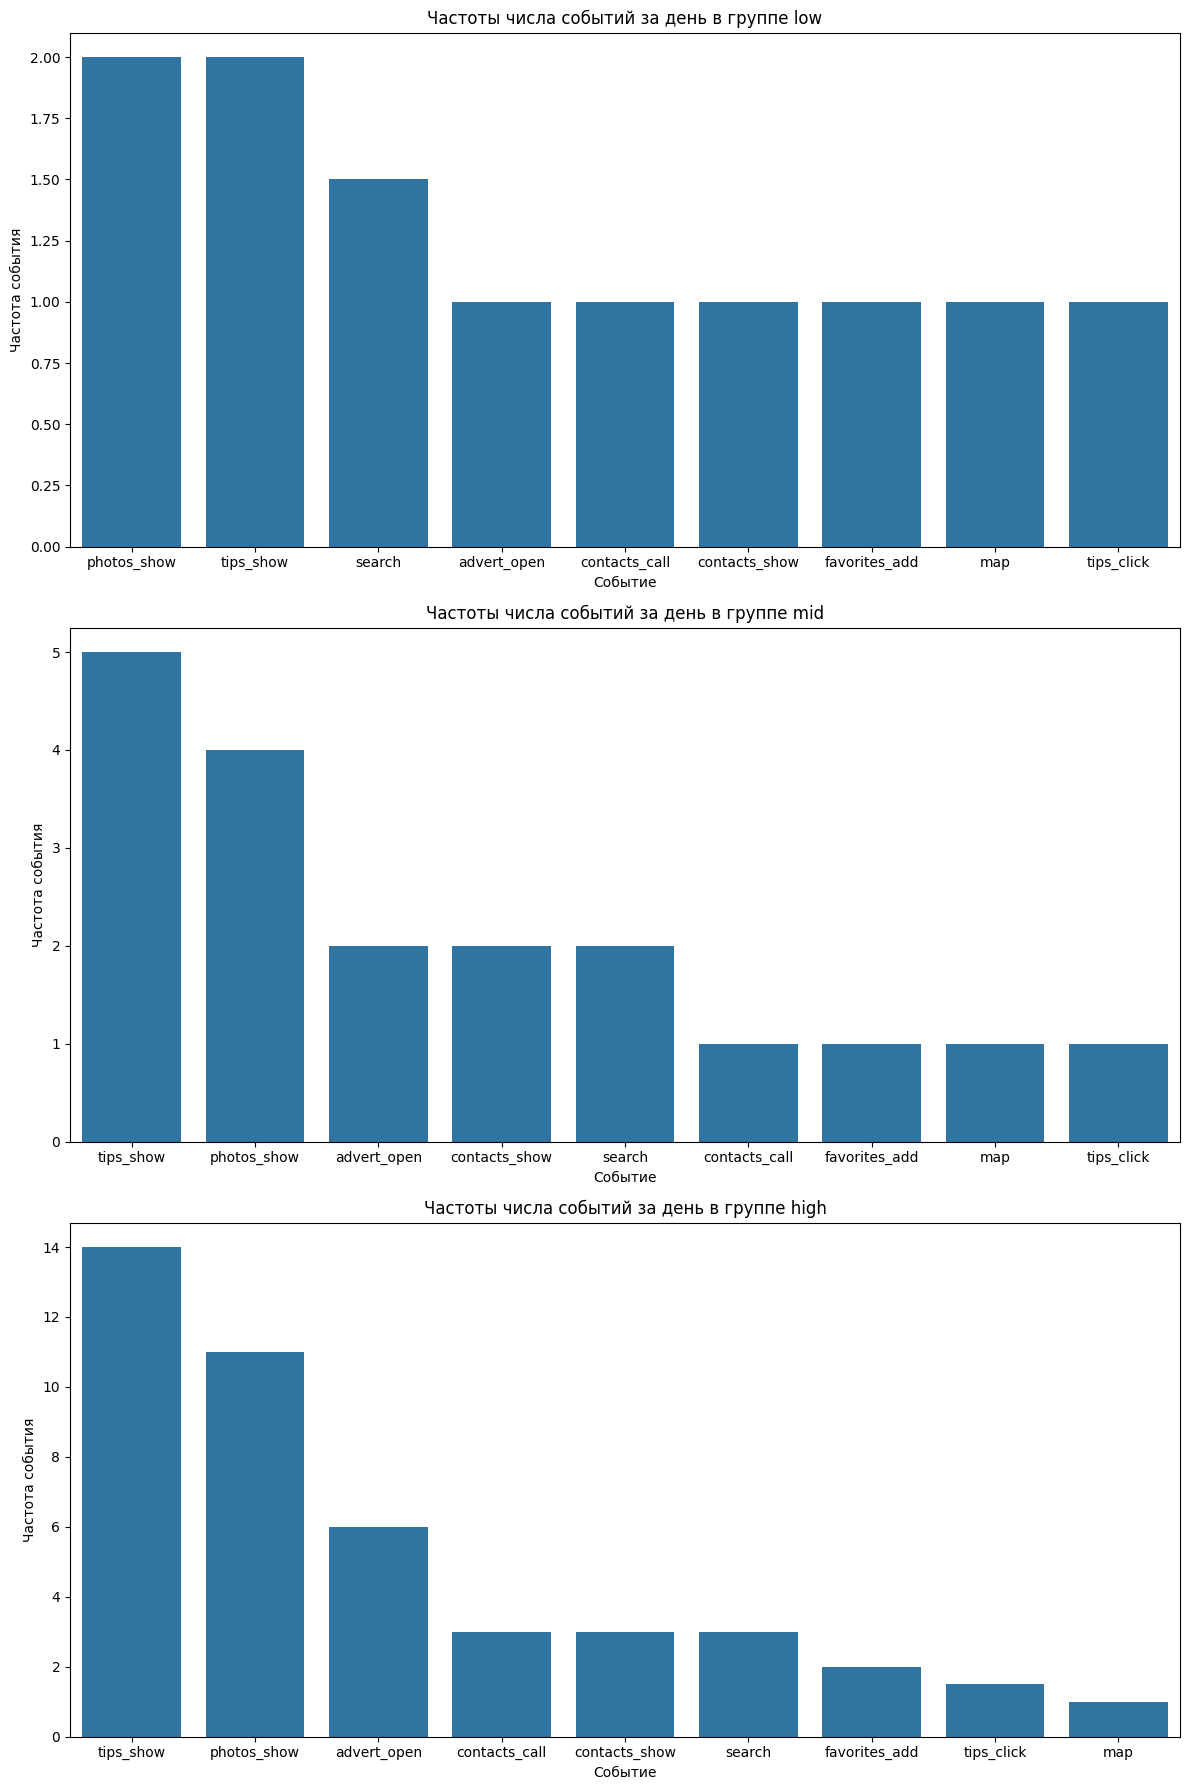

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
for i, group_value in enumerate(['low', 'mid', 'high']):
    data_slice = data.query('group == @group_value')
    sns.barplot(
        data=(
            # Число событий каждого типа у каждого пользователя за каждый день,
            data_slice[['event_time', 'user_id', 'event_name', 'event_date']]
            .groupby(['event_name', 'event_date', 'user_id'], as_index=False)
            .count()
            # Получим медиану каждого события по сессиям.
            .groupby(['event_name'], as_index=False)
            .agg({'event_time': 'median'})
            .sort_values(by='event_time', ascending=False)
        ),
        y='event_time',
        x='event_name',
        ax=axes.flatten()[i],
        figure=fig
    ).set(
        title='Частоты числа событий за день в группе {}'.format(group_value),
        xlabel='Событие',
        ylabel='Частота события'
    )

plt.tight_layout()

* Первые два события во всех группах одинаковы: просмотр рекомендаций и просмотр фото;
* Стоит заметить, что пользователи, которые совершают меньше действий практичнее: они ищут объявления сами чаще, чем другие.

### Конверсия в просмотр контактов.

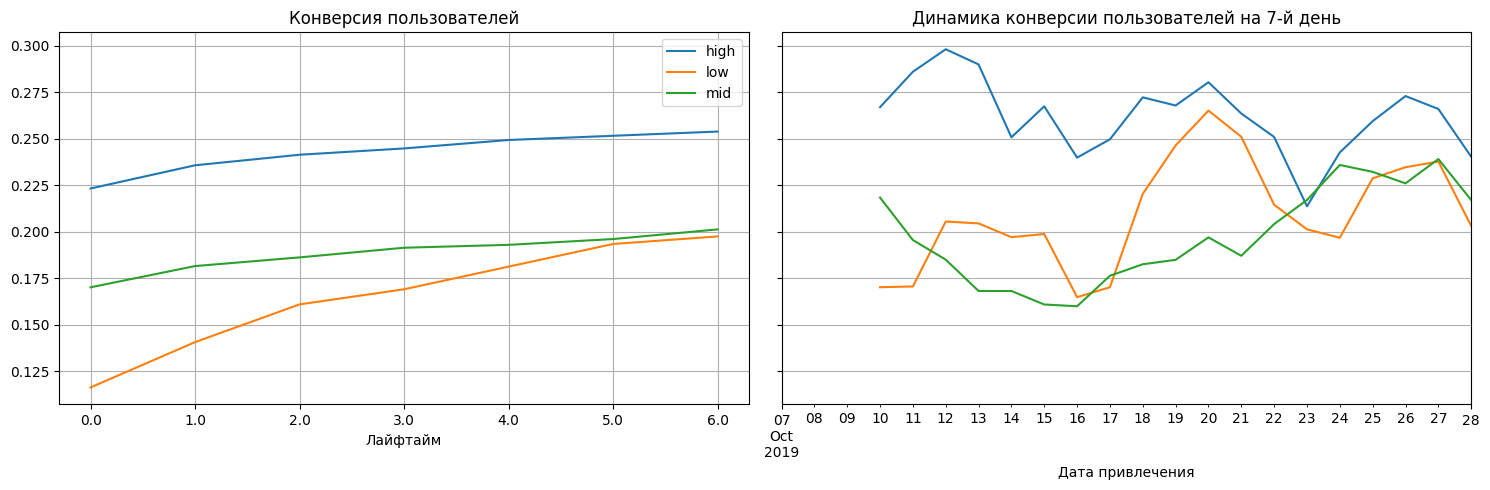

In [41]:
_, conversion, conversion_history = get_conversion(data, horizon_days=7, dimensions=['group'])
plot_conversion(conversion, conversion_history, horizon=7, window=4)

Пользователи, совершающие больше действий, чаще совершают целевое действие - просматривают контакты.

### Вывод.

**Удержание:**

* Удержание пользователей, которые совершают мало действий заметно больше, чем удержание остальных;
* В период с 17 по 19 число наблюдался большой прирост пользователей, совершающих много действий, которые остались заинтересованы в приложении. Исследование этого промежутка может помочь понять, как привлечь таких пользователей.

**Время в приложении:**
* Чем больше действия совершают пользователи, тем больше времени в среднем они проводят в приложении, как и ожидалось.

**Частота действий:**
* Два самых частых события во всех группах одинаковы: просмотр рекомендаций и просмотр фото;
* Стоит заметить, что пользователи, которые совершают меньше действий пользуются поиском чаще, чем другие.

**Конверсия в просмотр контактов:**
* Пользователи, совершающие больше действий, намного чаще совершают целевое действие - просматривают контакты.

## Проверка гипотез.

### Зависимость конверсии в просмотр контактов от источника привлечения.

Некоторые пользователи установили приложение по ссылке из yandex , другие — из google. Проверим следующую гипотезу: 

* $H_0$: две эти группы демонстрируют одинаковую конверсию в просмотры контактов;
* $H_1$: конверсия разная, есть стат. значимые различия.

Для проверки гипотезы подойдет Z-критерий по долям, пользователи между группами не пересекаются, поэтому он применим.

In [42]:
# Объединяю таблицы
data = data.merge(
    sources,
    on='user_id',
    how='left'
)

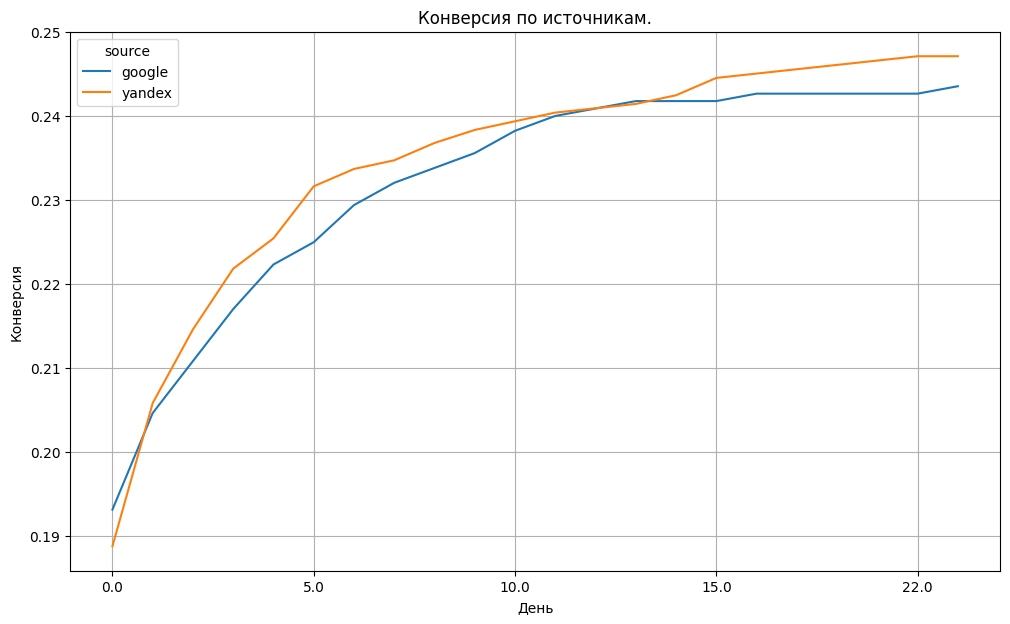

In [43]:
# Делаю срез и вычисляю конверсии
data_filtered = data.query('source != "other"')
conversions = get_conversion(data_filtered, dimensions=['source'], ignore_horizon=True)[1]
conversions = conversions.drop(columns='cohort_size')

conversions.T.plot(
    figsize=(12, 7),
    grid='True',
    title='Конверсия по источникам.',
    xlabel='День',
    ylabel='Конверсия'
);

In [44]:
data.head()

event_time event_name                               user_id  \
0 2019-10-07 13:39:45.989359  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
1 2019-10-07 13:40:31.052909  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
2 2019-10-07 13:41:05.722489  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
3 2019-10-07 13:43:20.735461  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   
4 2019-10-07 13:45:30.917502  tips_show  0001b1d5-b74a-4cbf-aeb0-7df5947bf349   

  event_date first_date  lifetime  event_median group source  
0 2019-10-07 2019-10-07         0           8.5   mid  other  
1 2019-10-07 2019-10-07         0           8.5   mid  other  
2 2019-10-07 2019-10-07         0           8.5   mid  other  
3 2019-10-07 2019-10-07         0           8.5   mid  other  
4 2019-10-07 2019-10-07         0           8.5   mid  other

In [45]:
alpha = 0.05
# Делаю срезы групп
group_a = data.query('source == "yandex"')
group_b = data.query('source == "google"')
count = (
    group_a.query('event_name == "contacts_show"')['user_id'].nunique(),
    group_b.query('event_name == "contacts_show"')['user_id'].nunique()
)
nobs = (
    group_a['user_id'].nunique(),
    group_b['user_id'].nunique()
)

print('Доля пользователей, совершивших целевое действие, в группе Яндекса:', round(count[0] / nobs[0], 2))
print('Доля пользователей, совершивших целевое действие, в группе Гугла:', round(count[1] / nobs[1], 2))

Доля пользователей, совершивших целевое действие, в группе Яндекса: 0.25
Доля пользователей, совершивших целевое действие, в группе Гугла: 0.24


In [46]:
_, pval = proportions_ztest(count, nobs)

print('p-значение:', round(pval, 2))

if pval < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение: 0.82
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Вывод:** сделать вывод о различии конверсии в просмотры контактов между пользователями из Яндекса и Гугла нельзя.

### Зависимость конверсии в просмотр контактов от количества событий.

Проверим ещё одну гипотезу:
* $H_0:$ пользователи, которые совершают много действий и мало действий демонстрируют одинаковую конверсию в просмотр контактов;
* $H_1:$ конверсия разная, есть стат. значимые различия.

Снова применим Z-критерий по долям, пользователи между группами опять не пересекаются, поэтому он применим.

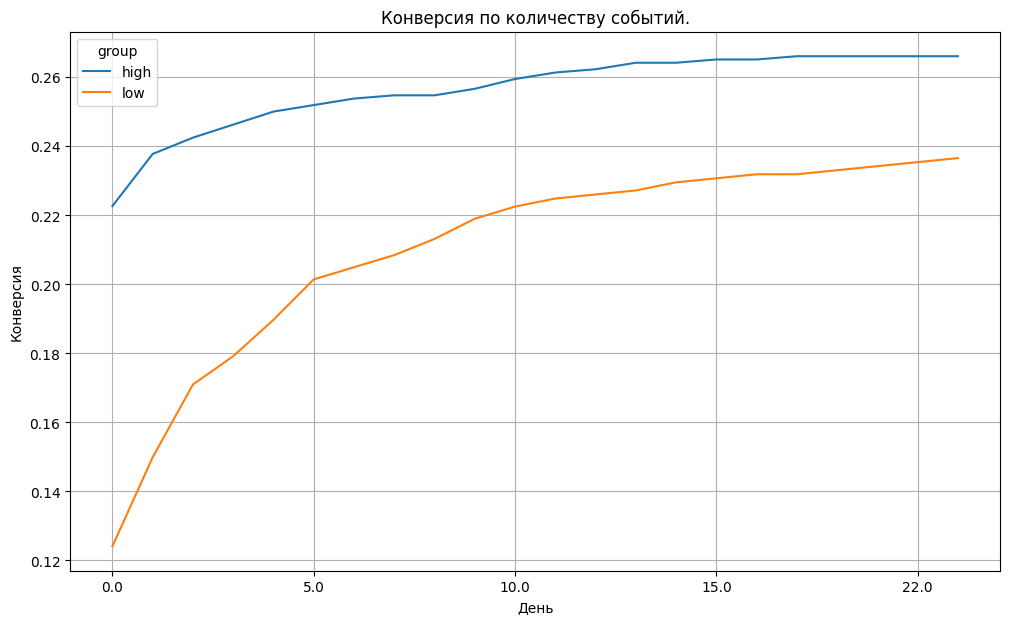

In [47]:
# Оставим только пользователей, которые совершают много или мало действий
data_filtered = data.query('group != "mid"')

conversions = get_conversion(data_filtered, dimensions=['group'], ignore_horizon=True)[1]
conversions = conversions.drop(columns='cohort_size')

conversions.T.plot(
    figsize=(12, 7),
    grid='True',
    title='Конверсия по количеству событий.',
    xlabel='День',
    ylabel='Конверсия'
);

In [48]:
alpha = 0.05
# Делаю срезы групп
group_a = data.query('group == "high"')
group_b = data.query('group == "low"')
count = (
    group_a.query('event_name == "contacts_show"')['user_id'].nunique(),
    group_b.query('event_name == "contacts_show"')['user_id'].nunique()
)
nobs = (
    group_a['user_id'].nunique(),
    group_b['user_id'].nunique()
)

print('Доля пользователей, совершивших целевое действие, в группе, которая делает много действий:', round(count[0] / nobs[0], 2))
print('Доля пользователей, совершивших целевое действие, в группе, которая делает мало действий:', round(count[1] / nobs[1], 2))

Доля пользователей, совершивших целевое действие, в группе, которая делает много действий: 0.27
Доля пользователей, совершивших целевое действие, в группе, которая делает мало действий: 0.24


In [49]:
_, pval = proportions_ztest(count, nobs)

print('p-значение:', round(pval, 2))

if pval < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

p-значение: 0.14
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


**Вывод:** нельзя сделать вывод о том, что пользователи, которые совершают много действий имеют конверсию отличную от пользователей, совершающих мало действий.

## Общий вывод.

### Вывод из предобработки.

* Пропусков нет;
* Единственный дубликат - это значения 'show_contacts' и 'contacts_show' в столбце `event_name`.

### Вывод из исследовательского анализа данных.

* Данные охватывают промежуток с 2019-10-07 по 2019-11-03;
* В каждый из дней совершалось не менее 1800 событий;
* Пользователей, пришедших от Яндекса, намного больше, чем от Гугла или других источников.

### Вывод из общего поведения пользователей.

**Удержание:**
* Retention rate позволил понять, что при разбиении пользователей по дням их прихода к 4 дню уходит около 90% пользователей каждой когорты;
* Пользователи, которые не ушли в первые дни, заходят в прилоэение не каждый день - например в когорте от 2019-10-21 с 6 на 7 день вернулось около 7% пользователей;
* Через 10 дней в приложении остается около 4% пользователей.

**Время в приложении:**
* В среднем пользователи проводят в приложении около 11 минут - листают объявления не долго.

**Частота действий:**
* Пользователи видят рекомендованные объявления примерно 5 раз в день;
* Пользователи смотрят 3 объявления в день и одно из них рекомендованное;
* Пользователи совершают целевое действие - просмотр контактов около 2 раз за сессию.

**Конверсия в просмотр контактов:**
* К концу недели конверсия достигает примерно 21%, начиная с 16-го числа конверсия, достигаемая на 7-ой день, возросла примерно на 4%.

### Вывод из поведения пользователей по группам.

Пользователи были сегментированы на 3 группы: совершающие мало действий за сессию, много действий, и около среднего числа действий. Затем пользователи были проанализированы в разрезе по этим группам.

**Удержание:**
* Удержание пользователей, которые совершают мало действий заметно больше, чем удержание остальных;
* В период с 17 по 19 число наблюдался большой прирост пользователей, совершающих много действий, которые остались заинтересованы в приложении. Исследование этого промежутка может помочь понять, как привлечь таких пользователей.

**Время в приложении:**
* Чем больше действия совершают пользователи, тем больше времени в среднем они проводят в приложении, как и ожидалось.

**Частота действий:**
* Два самых частых события во всех группах одинаковы: просмотр рекомендаций и просмотр фото;
* Стоит заметить, что пользователи, которые совершают меньше действий пользуются поиском чаще, чем другие.

**Конверсия в просмотр контактов:**
* Пользователи, совершающие больше действий, намного чаще совершают целевое действие - просматривают контакты.

### Результаты проверки гипотез.

**Первая гипотеза.**

Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Была проверена следующая гипотеза: 

* $H_0$: две эти группы демонстрируют одинаковую конверсию в просмотры контактов;
* $H_1$: конверсия разная, есть стат. значимые различия.

**Результат:** сделать вывод о различии конверсии в просмотры контактов между пользователями из Яндекса и Гугла нельзя.

**Вторая гипотеза.**

* $H_0:$ пользователи, которые совершают много действий и мало действий демонстрируют одинаковую конверсию в просмотр контактов;
* $H_1:$ пользователи, которые совершают много действий имеют большую конверсию в просмотр контактов (односторонняя альтернатива).

**Результат:** нельзя сделать вывод о том, что пользователи, которые совершают много действий имеют отличую конверсию от пользователей, совершающих мало действий.

### Рекомендации.

* Все результаты указывают на то, что выгодно сделать упор на пользователей, которые совершают много событий в приложении;
* Возможно исследование периода с 17 по 19 число поможет понять, как это сделать - многие пользователи интересуемой группы, привлеченные в этой период, продолжили пользоваться приложением, а не бросили его в первые пару дней.

## Презентация.

Ссылка на презентацию: https://drive.google.com/file/d/1W7oG8toOWgVBnl4A2zAqkKz-dlV1xZ65/view?usp=drive_link